In [1]:
import numpy as np
import pandas as pd
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Tuple, Optional
import os
import missingno as msno

from sklearn.model_selection import KFold, StratifiedKFold, GroupKFold, train_test_split, cross_val_score, GroupShuffleSplit
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import OrdinalEncoder

from src.utils import show_feature_importances

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
pd.options.display.max_columns = 400

### Загрузка датасета

In [3]:
data_path='./data/'

train_data = pd.read_csv(os.path.join(data_path, "train.csv"))
applications_history_data = pd.read_csv(os.path.join(data_path, "applications_history.csv"))

print("payments_data.shape = {} rows, {} cols".format(*applications_history_data.shape))

payments_data.shape = 1670214 rows, 26 cols


# Results

In [4]:
applications_history_data['DAYS_FIRST_DRAWING'][applications_history_data['DAYS_FIRST_DRAWING']==365243] = np.nan
applications_history_data['DAYS_FIRST_DUE'][applications_history_data['DAYS_FIRST_DUE']==365243] = np.nan
applications_history_data['DAYS_LAST_DUE_1ST_VERSION'][applications_history_data['DAYS_LAST_DUE_1ST_VERSION']==365243] = np.nan
applications_history_data['DAYS_LAST_DUE'][applications_history_data['DAYS_LAST_DUE']==365243] = np.nan
applications_history_data['DAYS_TERMINATION'][applications_history_data['DAYS_TERMINATION']==365243] = np.nan

In [5]:
applications_history_data.head(3)

,PREV_APPLICATION_NUMBER,APPLICATION_NUMBER,NAME_CONTRACT_TYPE,AMOUNT_ANNUITY,AMT_APPLICATION,AMOUNT_CREDIT,AMOUNT_PAYMENT,AMOUNT_GOODS_PAYMENT,NAME_CONTRACT_STATUS,DAYS_DECISION,NAME_PAYMENT_TYPE,CODE_REJECT_REASON,NAME_TYPE_SUITE,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,SELLERPLACE_AREA,CNT_PAYMENT,NAME_YIELD_GROUP,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,49298709,123595216,NaN,1730.430,17145.0,17145.0,0.0,17145.0,Approved,73,Cash through the bank,XAP,NaN,Repeater,Mobile,POS,XNA,35,12.0,middle,NaN,42.0,300.0,42.0,37.0,0.0
1,50070639,123431468,Cash,25188.615,607500.0,679671.0,NaN,607500.0,Approved,164,XNA,XAP,Unaccompanied,Repeater,XNA,Cash,x-sell,-1,36.0,low_action,NaN,134.0,916.0,NaN,NaN,1.0
2,49791680,123445379,Cash,15060.735,112500.0,136444.5,NaN,112500.0,Approved,301,Cash through the bank,XAP,"Spouse, partner",Repeater,XNA,Cash,x-sell,-1,12.0,high,NaN,271.0,59.0,NaN,NaN,1.0


In [6]:
applications_history_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1670214 entries, 0 to 1670213
Data columns (total 26 columns):
 #   Column                     Non-Null Count    Dtype  
---  ------                     --------------    -----  
 0   PREV_APPLICATION_NUMBER    1670214 non-null  int64  
 1   APPLICATION_NUMBER         1670214 non-null  int64  
 2   NAME_CONTRACT_TYPE         940717 non-null   object 
 3   AMOUNT_ANNUITY             1297979 non-null  float64
 4   AMT_APPLICATION            1670214 non-null  float64
 5   AMOUNT_CREDIT              1670213 non-null  float64
 6   AMOUNT_PAYMENT             774370 non-null   float64
 7   AMOUNT_GOODS_PAYMENT       1284699 non-null  float64
 8   NAME_CONTRACT_STATUS       1670214 non-null  object 
 9   DAYS_DECISION              1670214 non-null  int64  
 10  NAME_PAYMENT_TYPE          1670214 non-null  object 
 11  CODE_REJECT_REASON         1670214 non-null  object 
 12  NAME_TYPE_SUITE            849809 non-null   object 
 13  NAME_CLIENT_

In [7]:
applications_history_data.describe()

,PREV_APPLICATION_NUMBER,APPLICATION_NUMBER,AMOUNT_ANNUITY,AMT_APPLICATION,AMOUNT_CREDIT,AMOUNT_PAYMENT,AMOUNT_GOODS_PAYMENT,DAYS_DECISION,SELLERPLACE_AREA,CNT_PAYMENT,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
count,1.670214e+06,1.670214e+06,1.297979e+06,1.670214e+06,1.670213e+06,7.743700e+05,1.284699e+06,1.670214e+06,1.670214e+06,1.297984e+06,62705.000000,956504.000000,903285.000000,785928.000000,771236.000000,997149.000000
mean,4.919130e+07,1.236017e+08,1.595512e+04,1.752339e+05,1.961140e+05,6.697402e+03,2.278473e+05,8.806797e+02,3.139511e+02,1.605408e+01,1035.246791,1106.583027,863.452359,996.179128,978.375222,0.332570
std,5.325980e+05,1.028148e+05,1.478214e+04,2.927798e+05,3.185746e+05,2.092150e+04,3.153966e+05,7.790997e+02,7.127443e+03,1.456729e+01,922.710316,790.703113,752.350974,752.703178,749.134297,0.471134
min,4.826822e+07,1.234233e+08,0.000000e+00,0.000000e+00,0.000000e+00,-9.000000e-01,0.000000e+00,1.000000e+00,-1.000000e+00,0.000000e+00,2.000000,2.000000,0.000000,2.000000,2.000000,0.000000
25%,4.873007e+07,1.235127e+08,6.321780e+03,1.872000e+04,2.416050e+04,0.000000e+00,5.084100e+04,2.800000e+02,-1.000000e+00,6.000000e+00,303.000000,459.000000,227.000000,353.000000,337.000000,0.000000
50%,4.919132e+07,1.236021e+08,1.125000e+04,7.104600e+04,8.054100e+04,1.638000e+03,1.123200e+05,5.810000e+02,3.000000e+00,1.200000e+01,621.000000,874.000000,615.000000,801.000000,780.000000,0.000000
75%,4.965249e+07,1.236909e+08,2.065842e+04,1.803600e+05,2.164185e+05,7.740000e+03,2.340000e+05,1.300000e+03,8.200000e+01,2.400000e+01,1721.000000,1676.000000,1393.000000,1566.000000,1539.000000,1.000000
max,5.011360e+07,1.237796e+08,4.180581e+05,6.905160e+06,6.905160e+06,3.060045e+06,6.905160e+06,2.922000e+03,4.000000e+06,8.400000e+01,2922.000000,2892.000000,2801.000000,2889.000000,2874.000000,1.000000


In [8]:
for col in applications_history_data.columns[2:]:
    print(f'{col}: n_uniques:{applications_history_data[col].nunique()} list:{applications_history_data[col].unique()}')

NAME_CONTRACT_TYPE: n_uniques:2 list:[nan 'Cash' 'Credit Card']
AMOUNT_ANNUITY: n_uniques:357959 list:[ 1730.43  25188.615 15060.735 ... 15708.15   8546.94  14704.29 ]
AMT_APPLICATION: n_uniques:93885 list:[ 17145.   607500.   112500.   ... 332596.08 373230.72 267295.5 ]
AMOUNT_CREDIT: n_uniques:86803 list:[ 17145.   679671.   136444.5  ... 977724.   626796.   436370.22]
AMOUNT_PAYMENT: n_uniques:29278 list:[    0.        nan 12649.5  ...  4099.95 55325.25 50476.5 ]
AMOUNT_GOODS_PAYMENT: n_uniques:93885 list:[ 17145.   607500.   112500.   ... 332596.08 373230.72 267295.5 ]
NAME_CONTRACT_STATUS: n_uniques:4 list:['Approved' 'Refused' 'Canceled' 'Unused offer']
DAYS_DECISION: n_uniques:2922 list:[  73  164  301 ... 1967 2389    1]
NAME_PAYMENT_TYPE: n_uniques:4 list:['Cash through the bank' 'XNA' 'Non-cash from your account'
 'Cashless from the account of the employer']
CODE_REJECT_REASON: n_uniques:9 list:['XAP' 'HC' 'LIMIT' 'CLIENT' 'SCOFR' 'SCO' 'XNA' 'VERIF' 'SYSTEM']
NAME_TYPE_SUITE

In [9]:
data = applications_history_data.merge(train_data[['APPLICATION_NUMBER', 'TARGET']], how='left', on='APPLICATION_NUMBER')
data = data.dropna(subset=['TARGET'])
data = data.reset_index(drop=True)

In [10]:
numerical_features = data.drop(['APPLICATION_NUMBER', 'PREV_APPLICATION_NUMBER', 'TARGET'], axis=1).select_dtypes(include=[np.number]).columns
categorical_features = data.select_dtypes(include=[np.object]).columns

In [11]:
data[numerical_features].head(5)

,AMOUNT_ANNUITY,AMT_APPLICATION,AMOUNT_CREDIT,AMOUNT_PAYMENT,AMOUNT_GOODS_PAYMENT,DAYS_DECISION,SELLERPLACE_AREA,CNT_PAYMENT,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,25188.615,607500.0,679671.0,NaN,607500.0,164,-1,36.0,NaN,134.0,916.0,NaN,NaN,1.0
1,15060.735,112500.0,136444.5,NaN,112500.0,301,-1,12.0,NaN,271.0,59.0,NaN,NaN,1.0
2,47041.335,450000.0,470790.0,NaN,450000.0,512,-1,12.0,NaN,482.0,152.0,182.0,177.0,1.0
3,23703.930,315000.0,340573.5,NaN,315000.0,684,-1,18.0,NaN,654.0,144.0,144.0,137.0,1.0
4,NaN,0.0,0.0,NaN,NaN,14,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
data[categorical_features].head(5)

,NAME_CONTRACT_TYPE,NAME_CONTRACT_STATUS,NAME_PAYMENT_TYPE,CODE_REJECT_REASON,NAME_TYPE_SUITE,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,NAME_YIELD_GROUP
0,Cash,Approved,XNA,XAP,Unaccompanied,Repeater,XNA,Cash,x-sell,low_action
1,Cash,Approved,Cash through the bank,XAP,"Spouse, partner",Repeater,XNA,Cash,x-sell,high
2,Cash,Approved,Cash through the bank,XAP,NaN,Repeater,XNA,Cash,x-sell,middle
3,Cash,Approved,Cash through the bank,XAP,Family,Repeater,XNA,Cash,x-sell,low_normal
4,Cash,Canceled,XNA,XAP,NaN,Repeater,XNA,XNA,XNA,XNA


In [13]:
for col in categorical_features:
    print(f'{col}: n_uniques:{applications_history_data[col].nunique()} list:{applications_history_data[col].unique()}')

NAME_CONTRACT_TYPE: n_uniques:2 list:[nan 'Cash' 'Credit Card']
NAME_CONTRACT_STATUS: n_uniques:4 list:['Approved' 'Refused' 'Canceled' 'Unused offer']
NAME_PAYMENT_TYPE: n_uniques:4 list:['Cash through the bank' 'XNA' 'Non-cash from your account'
 'Cashless from the account of the employer']
CODE_REJECT_REASON: n_uniques:9 list:['XAP' 'HC' 'LIMIT' 'CLIENT' 'SCOFR' 'SCO' 'XNA' 'VERIF' 'SYSTEM']
NAME_TYPE_SUITE: n_uniques:7 list:[nan 'Unaccompanied' 'Spouse, partner' 'Family' 'Children' 'Other_B'
 'Other_A' 'Group of people']
NAME_CLIENT_TYPE: n_uniques:4 list:['Repeater' 'New' 'Refreshed' 'XNA']
NAME_GOODS_CATEGORY: n_uniques:28 list:['Mobile' 'XNA' 'Consumer Electronics' 'Construction Materials'
 'Auto Accessories' 'Photo / Cinema Equipment' 'Computers' 'Audio/Video'
 'Medicine' 'Clothing and Accessories' 'Furniture' 'Sport and Leisure'
 'Homewares' 'Gardening' 'Jewelry' 'Vehicles' 'Education'
 'Medical Supplies' 'Other' 'Direct Sales' 'Office Appliances' 'Fitness'
 'Tourism' 'Insuran

<AxesSubplot:>

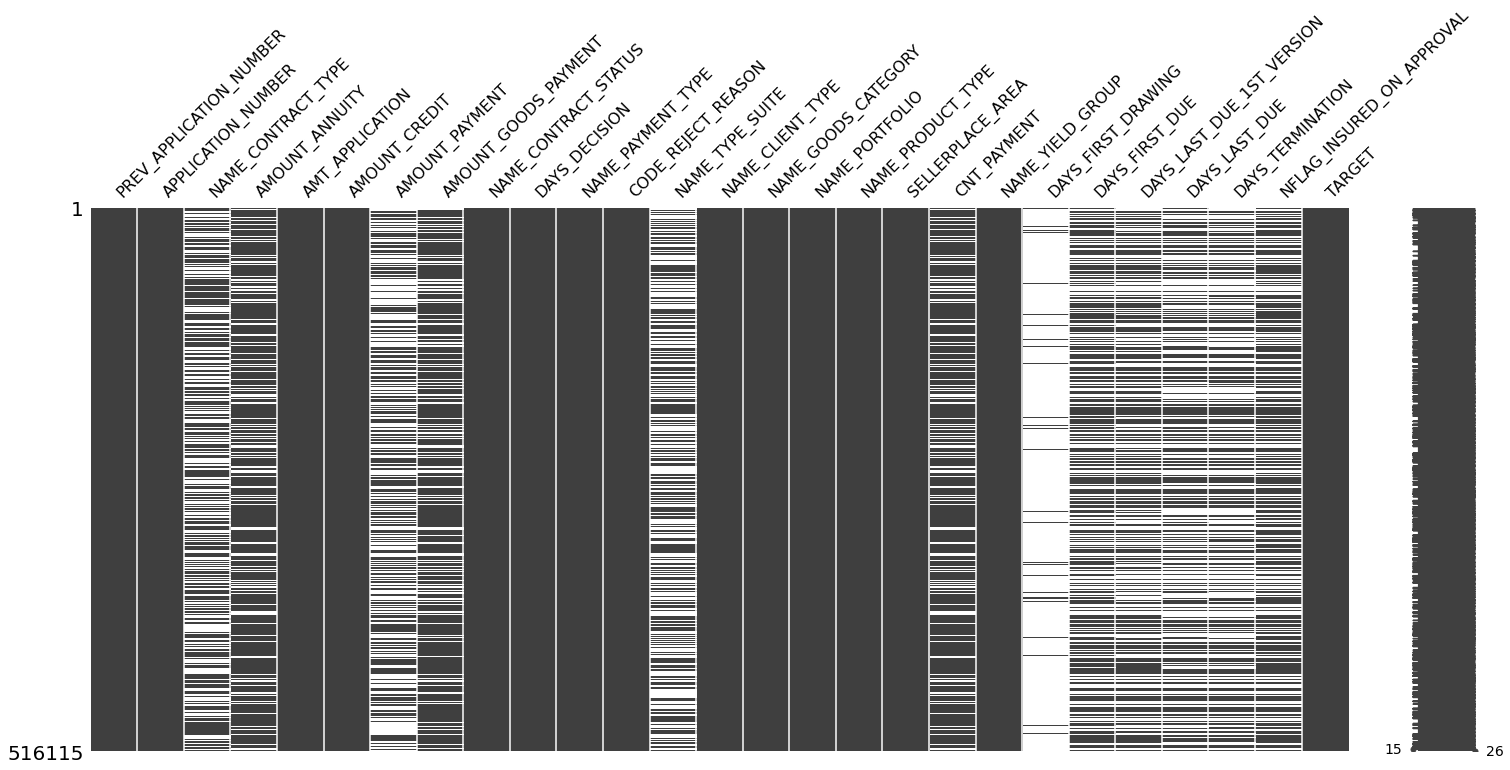

In [14]:
msno.matrix(data)

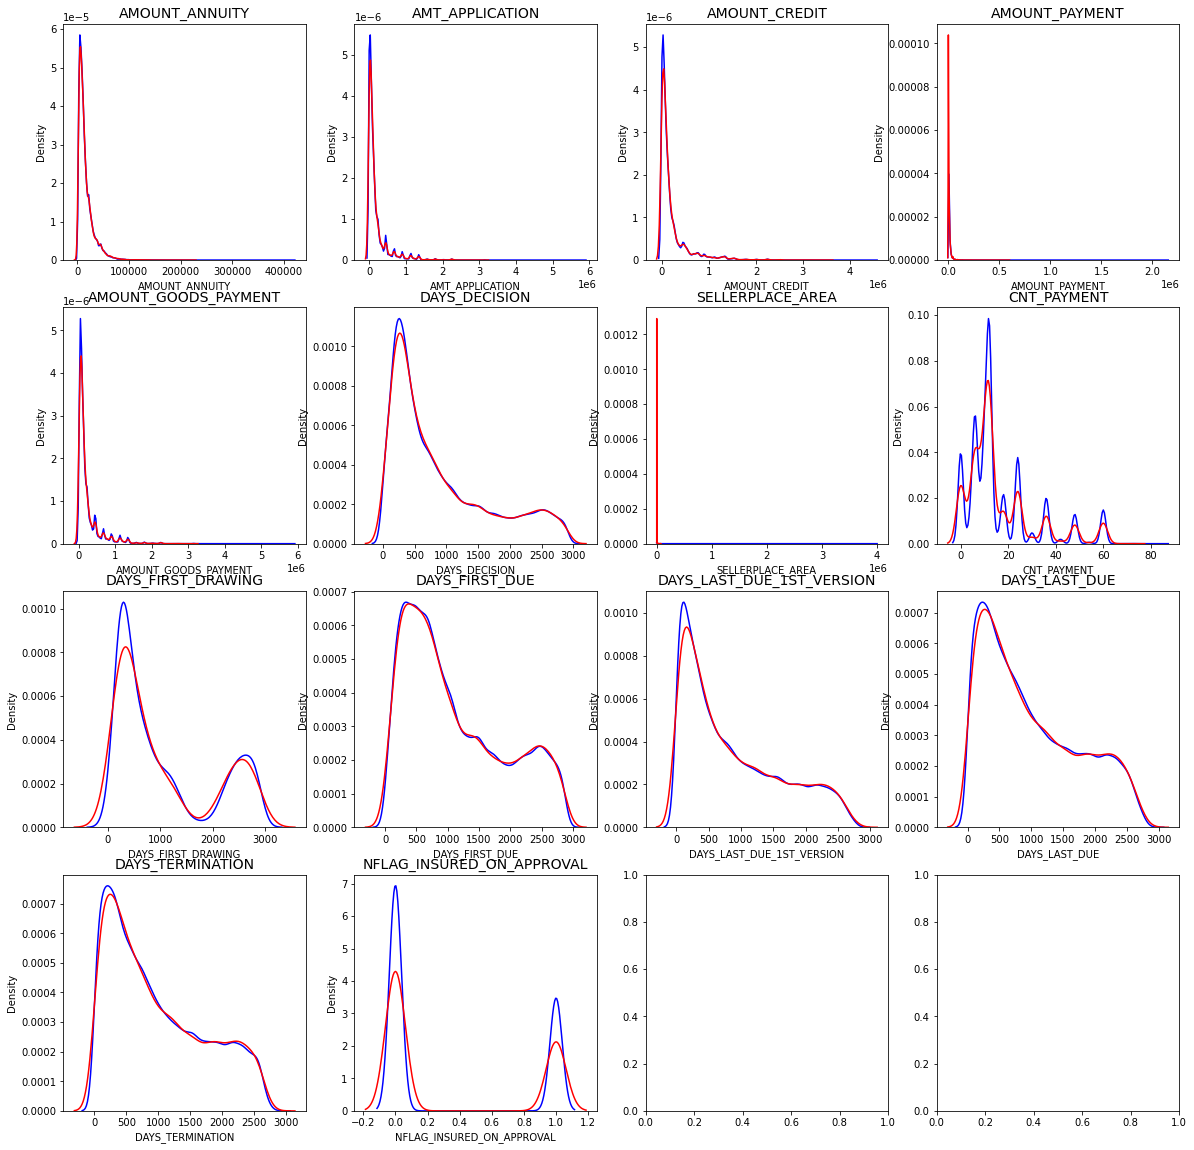

In [15]:
fig, axes = plt.subplots(4, 4, figsize=(20, 20))

for num, feature in enumerate(numerical_features):
    try:
        train_target_0, test_target_1 = data[data['TARGET']==0][feature].copy(), data[data['TARGET']==1][feature].copy()
        sns.kdeplot(train_target_0, ax=axes[num//4, num%4], color="blue", label="target=0")
        sns.kdeplot(test_target_1, ax=axes[num//4, num%4], color="red", label="target=1")
    except RuntimeError:
        pass
    except KeyError:
        pass
    axes[num//4, num%4].set_title(feature, fontsize=14)

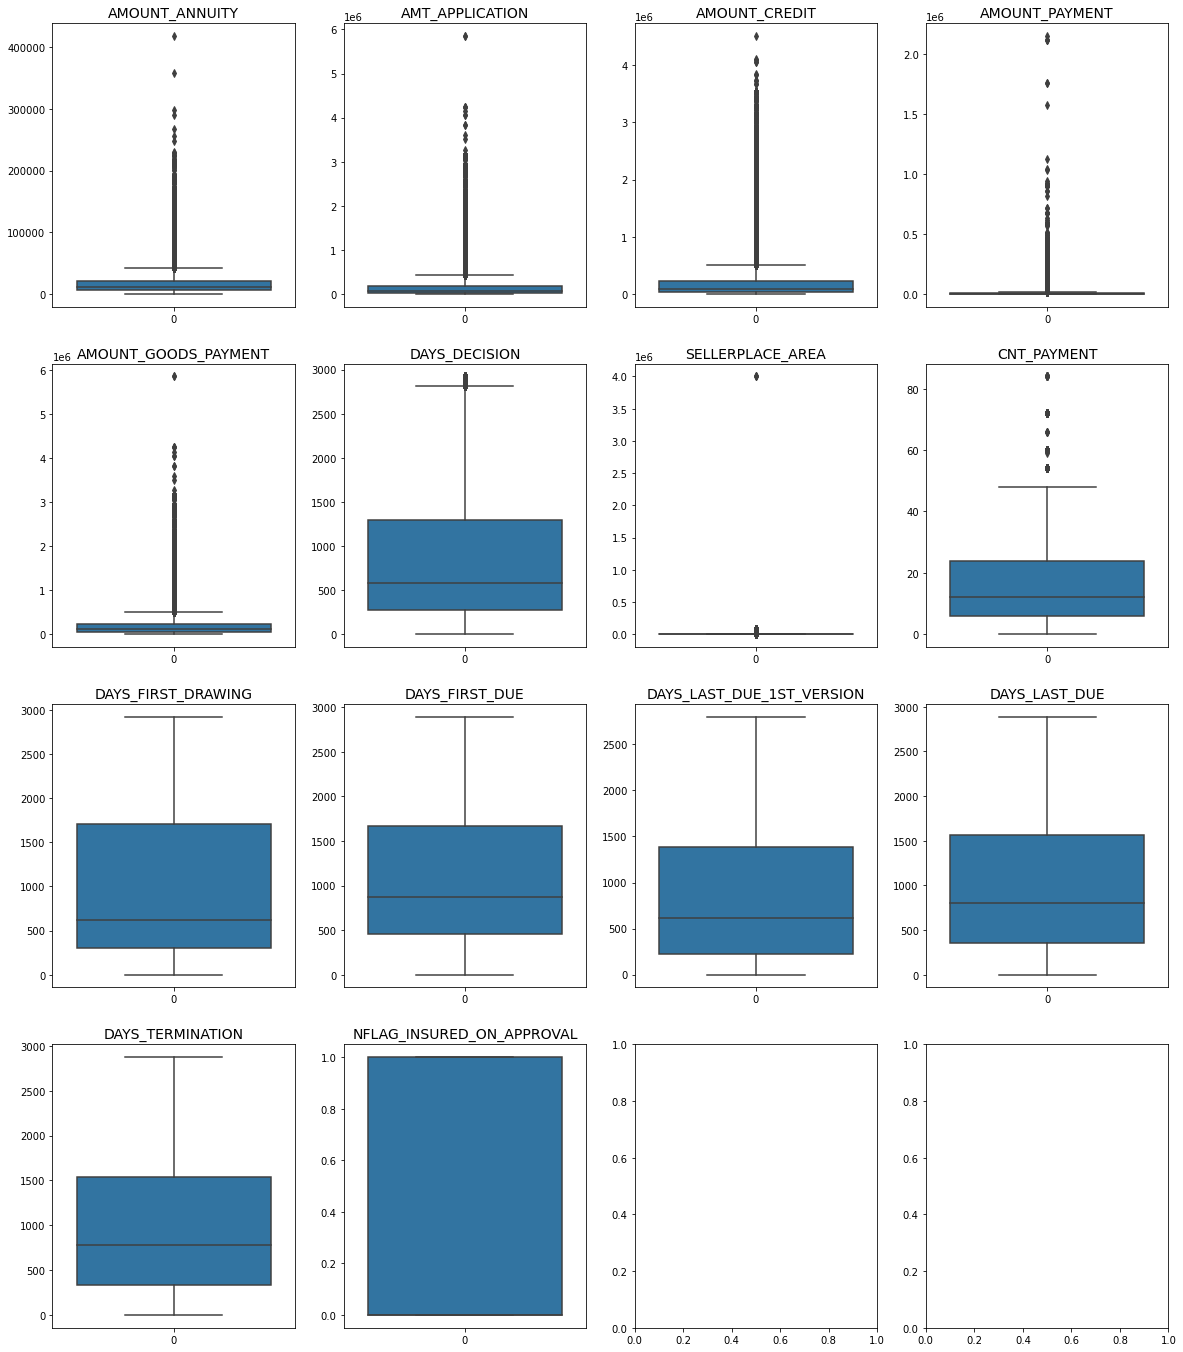

In [16]:
fig, axes = plt.subplots(4, 4, figsize=(20, 24))

for num, feature in enumerate(numerical_features):
    try:
        sns.boxplot(data=data[feature], ax=axes[num//4, num%4])
    except RuntimeError:
        pass
    except KeyError:
        pass
    axes[num//4, num%4].set_title(feature, fontsize=14)

In [17]:
correlation = data.corr()

<AxesSubplot:>

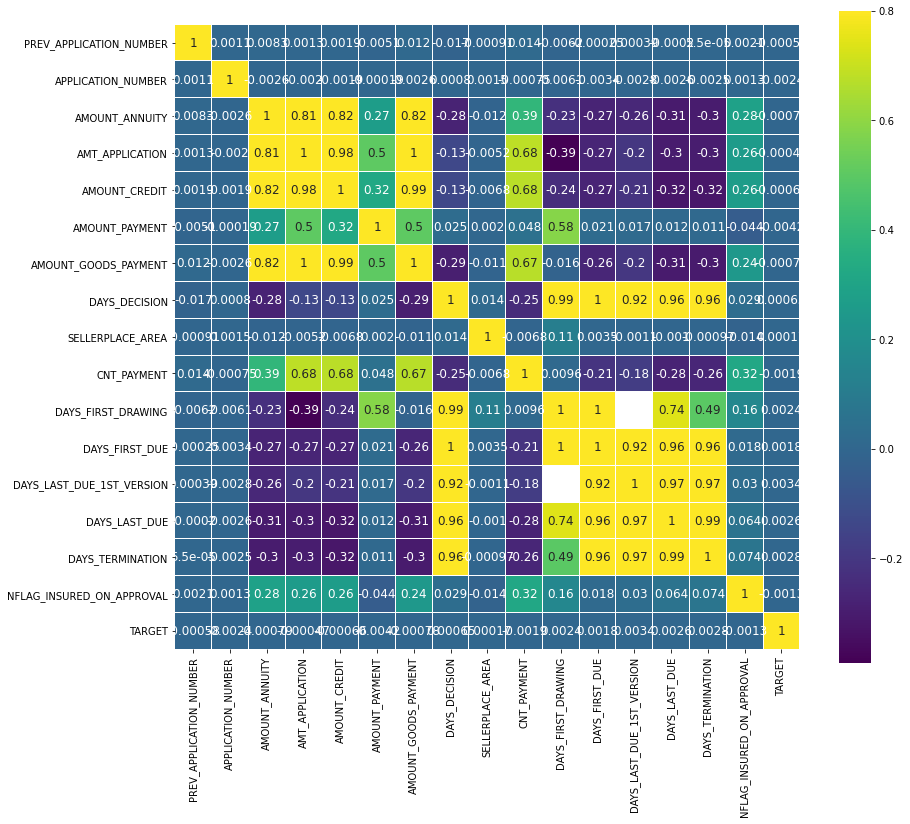

In [18]:
fig, axes = plt.subplots(figsize = (14, 12))
sns.heatmap(
    correlation,
    vmax=0.8,
    linewidths=0.01,
    cmap="viridis",
    square=True,
    annot=True,
    linecolor="white",
    xticklabels=correlation.columns,
    annot_kws = {"size": 12},
    yticklabels=correlation.columns
)